### Разработка двухуровненой модели рекомендательной системы (ALS)
##### Для отработки скрипта необходимо прописать путь к библиотеке src, а также пути к исходным csv - файлам
Для работы скрипта использовалась библиотека implicit 0.4.7

In [1]:
import pandas as pd
from src.recommenders import MainRecommender
from src.utils import prefilter_items
from src.metrics import recall_at_k, precision_at_k
from catboost import CatBoostClassifier
from src.metrics import precision_at_k, recall_at_k
from matplotlib import pyplot as plt
import seaborn as sns

#### Импорт исходных файлов:
- df_train - обучающий набор данных
- df_val - набор данных для валидации

In [2]:
# Введите абсолютные пути до исходных файлов здесь:
df_train = pd.read_csv(r'...\retail_train.csv')
df_val = pd.read_csv(r'...\retail_test1.csv')

In [3]:
'''
user_id - кто купил товар,
item_id - товар, который купили
quantity - количество
week_no - номер недели, когда была произведена покупка
'''
df_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [4]:
'''
описание - аналогично df_train
'''
df_val.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0


#### Разбиение датасета на обучающую и тестовую выборки. Логика следующая:
- Последние 5 недель оставим на тест, остальные 90 недель - на обучение

In [5]:
df_test = df_train[df_train['week_no'] > 90]
df_train = df_train[df_train['week_no'] <= 90]

### Рекомендательная система будет состоять из 2х уровней

#### Уровень 1. Префильтрация.
Убираем из рекомендаций товары, которые уже популярные (их и так купят), а также товары, которые почти никто не покупает. ID таких товаров приравниваем к 999999 (из обучения товары не пропадают)

In [6]:
print(f"До префильтрации было {df_train['item_id'].unique().shape[0]} товаров")
df_train = prefilter_items(df_train, take_n_popular = 3000, popularuty_level=0.2, non_popularity_level=0.02, fake_id = 999999)
print(f"После префильтрации стало {df_train['item_id'].unique().shape[0]} товаров")

До префильтрации было 86343 товаров
После префильтрации стало 3001 товаров


#### Уровень 2. ALS

Обучим две предсказательные системы - чтобы в дальнейшем выбрать наилучшую

In [7]:
als_recommender_bm25 = MainRecommender(df_train, weighting='bm25')
als_recommender_tfidf = MainRecommender(df_train, weighting='tfidf')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

#### В случае, если предсказанное количество рекомендаций менее требуемого количества (например, менее 5), то к ним автоматически будут добавлены рекомендации товаров из топа

In [8]:
# Вычисление предсказаний для пользователей, расчет precision - метрик на тесте
df_test_als_preds = pd.DataFrame({'user_id':df_test['user_id'].unique()})
df_test_als_preds['real_item_id'] = df_test_als_preds['user_id'].apply(lambda x: df_test[df_test['user_id'] == x]['item_id'].unique().tolist())

#bm25 recommendations
df_test_als_preds['predicted_item_id_bm25_5'] = df_test_als_preds['user_id'].apply(lambda x: als_recommender_bm25.get_als_recommendations(x, N=5))
df_test_als_preds['precision_at_5_bm25'] = df_test_als_preds.apply(lambda x: precision_at_k(x['predicted_item_id_bm25_5'], x['real_item_id']), axis = 1)

#tfidf recommendations
df_test_als_preds['predicted_item_id_tfidf_5'] = df_test_als_preds['user_id'].apply(lambda x: als_recommender_tfidf.get_als_recommendations(x, N=5))
df_test_als_preds['precision_at_5_tfidf'] = df_test_als_preds.apply(lambda x: precision_at_k(x['predicted_item_id_tfidf_5'], x['real_item_id']), axis = 1)

In [9]:
df_test_als_preds

,user_id,real_item_id,predicted_item_id_bm25_5,precision_at_5_bm25,predicted_item_id_tfidf_5,precision_at_5_tfidf
0,2445,"[847774, 863337, 864033, 889319, 909868, 91211...","[6463710, 1009368, 1029743, 7442180, 6463775]",0.2,"[1029743, 8090537, 1106523, 1043751, 1018740]",0.2
1,148,"[1008799, 5568729, 5581788, 1096643, 10204559,...","[5568489, 1043730, 5564901, 1046587, 7025203]",0.0,"[1029743, 834117, 5569230, 5569845, 913210]",0.2
2,537,"[1206022, 1256103, 1175649, 1216523, 1284630, ...","[1116635, 1128163, 1006664, 1044724, 12262992]",0.4,"[916122, 1029743, 897954, 985999, 1075368]",0.0
3,916,"[505280, 535652, 576787, 683346, 718226, 77848...","[860248, 849202, 9655679, 1034176, 1065538]",0.0,"[5569471, 1029743, 5569230, 1075368, 849202]",0.0
4,2200,"[840601, 923746, 965530, 995785, 1001298, 1046...","[1054567, 898466, 895680, 914318, 1009187]",0.0,"[1004906, 12301109, 844179, 999858, 8090537]",0.6
...,...,...,...,...,...,...
2096,1386,"[901302, 995242, 16769778]","[1110843, 1005186, 1063207, 1091365, 926422]",0.0,"[1005186, 1110843, 986912, 1091365, 1029743]",0.0
2097,472,[6553836],"[7169088, 934399, 7168026, 1054567, 1105301]",0.0,"[908318, 1042438, 872137, 883932, 866211]",0.0
2098,90,"[840890, 856519, 862535, 880438, 914077, 94229...","[862535, 13007846, 1019643, 1005274, 978343]",0.2,"[1029743, 1106523, 1070820, 1126899, 916122]",0.0
2099,1635,"[1036681, 998119, 1117128]","[823862, 8090440, 841309, 12731447, 919766]",0.0,"[1029743, 1106523, 5569230, 866211, 916122]",0.0


In [10]:
print(f"Средний precision для tfidf: {round(df_test_als_preds['precision_at_5_tfidf'].mean() * 100, 1)}%")
print(f"Средний precision для bm25: {round(df_test_als_preds['precision_at_5_bm25'].mean() * 100, 1)}%")

Средний precision для tfidf: 13.9%
Средний precision для bm25: 9.9%


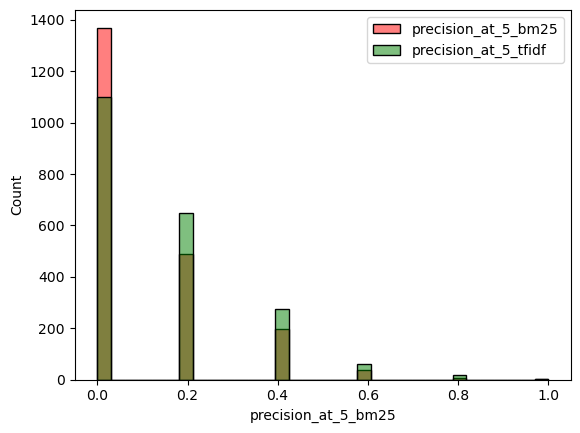

In [11]:
sns.histplot(df_test_als_preds, x='precision_at_5_bm25', label = 'precision_at_5_bm25', alpha=0.5, color='r')
sns.histplot(df_test_als_preds, x='precision_at_5_tfidf', label = 'precision_at_5_tfidf', alpha = 0.5, color='g')
plt.legend()
plt.show()

#### Вывод: ALS - модель, в которой веса рассчитываются при помощи tfidf, показала лучший результат, чем bm25. В дальнейшей работе рекомендуется использовать ее

#### Финальная проверка работы модели на валидационном датасете

In [12]:
df_val_als_preds = pd.DataFrame({'user_id':df_val['user_id'].unique()})
df_val_als_preds['real_item_id'] = df_val_als_preds['user_id'].apply(lambda x: df_val[df_val['user_id'] == x]['item_id'].unique().tolist())
df_val_als_preds['predicted_item_id'] = df_val_als_preds['user_id'].apply(lambda x: als_recommender_tfidf.get_als_recommendations(x, N=5))
df_val_als_preds['precision_at_5'] = df_val_als_preds.apply(lambda x: precision_at_k(x['predicted_item_id'], x['real_item_id']), axis = 1)

Средний precision_at_5 на валидационных данных: 10.6%


<AxesSubplot:>

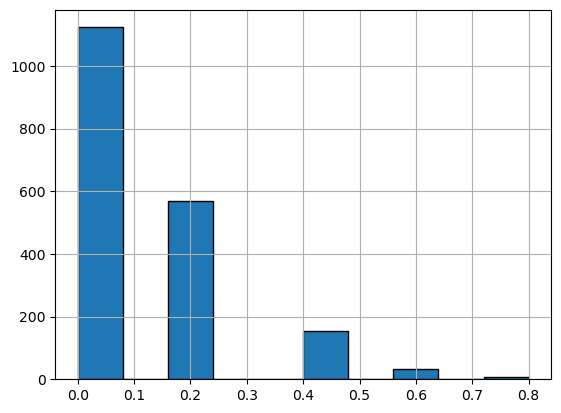

In [13]:
print(f"Средний precision_at_5 на валидационных данных: {round(df_val_als_preds['precision_at_5'].mean() * 100, 1)}%")
df_val_als_preds['precision_at_5'].hist(ec='black')

### Вывод:
Несмотря на то, что итоговая метрика проекта precision_at_5 составляет 10%, считаю ее недостаточно хорошей. Очевидно, что модель можно улучшить. Для этого можно попробовать следующие методы:
1. Изменить параметры обучения модели (на данный момент они зафиксированы при инициализации модели) - такие как количество итераций, регуляризация
2. Изменить параметры расчета взвешиваний TF-idf, bm25, или применить другие, более простые методы взвешивания (например, частота покупок)
3. Добавить третий и дальнейшие уровни рекомендаций